In [142]:
from pymongo import MongoClient
import os
import cv2
from sklearn.cluster import KMeans
import tensorflow as tf
import numpy as np


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from cropper_img import Cropping
cropper = Cropping()
import pickle

data_path = './cropped_data'

I0000 00:00:1735747131.508115  189155 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1735747131.512377  275597 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.3), renderer: Mesa Intel(R) Graphics (ADL GT2)


In [181]:
model = tf.keras.models.load_model('../model')  # Load the model

# Function to preprocess and encode images using a pre-trained model
def img_to_encoding(img_array):
    img_array = cv2.resize(img_array, (160, 160))  # Resize to the required shape
    img_array = np.around(img_array / 255.0, decimals=12)  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    embedding = model.predict_on_batch(img_array)
    return embedding / np.linalg.norm(embedding, ord=2)

# Function to load image vectors
def load_vectors():
    img_vectors = []
    for dir in os.listdir(data_path):
        dir_path = os.path.join(data_path, dir)
        if not os.path.isdir(dir_path):
            continue
        for file in os.listdir(dir_path):
            img_path = os.path.join(dir_path, file)
            img_array = cv2.imread(img_path)
            if img_array is None:
                print(f"Error reading {img_path}, skipping...")
                continue
            encoding = img_to_encoding(img_array)
            img_vectors.append({'name': dir, 'encoding': encoding.flatten()})
    return img_vectors

# Function to train the KMeans model
def train_model(img_vectors, clusters = 5):
    X = [img['encoding'] for img in img_vectors]

    kmeans = KMeans(n_clusters=clusters, random_state=0)
    kmeans.fit(X)
    return kmeans

In [144]:
client = MongoClient('localhost', 27017)

In [145]:
# Function to update the database (10m 42.6s)
print("Loading the vectors...")
img_vectors = load_vectors()
print("Loaded vectors")

Loading the vectors...
Loaded vectors


In [146]:
def save_list(file_name, data):
    with open(file_name, 'wb') as file:
        pickle.dump(data, file)
    print(f"List saved to {file_name}")

In [147]:
# DO NOT RUN THIS CELL ALWAYS
save_list('img_vectors.pkl', img_vectors)

List saved to img_vectors.pkl


In [148]:
def load_list(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    print(f"List loaded from {file_name}")
    return data

In [272]:
kmeans = train_model(img_vectors, 4)

In [273]:
%%time
db = client['optimized_image_db']
for img in img_vectors:
    class_name = str(kmeans.predict([img['encoding']])[0])
    collection = db[class_name]
    collection.insert_one({'name': img['name'], 'encoding': img['encoding'].tolist()})
print("Database updated")

Database updated
CPU times: user 179 ms, sys: 13.6 ms, total: 193 ms
Wall time: 282 ms


In [274]:
%%time
db = client['unoptimized_image_db']
collection = db['vectors']
for img in img_vectors:
    collection.insert_one({'name': img['name'], 'encoding': img['encoding'].tolist()})
print("Database updated")

Database updated
CPU times: user 85.3 ms, sys: 12.9 ms, total: 98.2 ms
Wall time: 149 ms


In [275]:
def check_in_collection(img, db):
    # print("test")
    img_vector = img_to_encoding(img)

    img_vector = [img_vector.flatten()]
    # print("test")
    class_name = str(kmeans.predict(img_vector)[0])
    # print("test1")
    collection = db[class_name]
    vectors = collection.find({})
    img_vector = np.array(img_vector)
    # print(vectors)
    for vector in vectors:
        if np.linalg.norm(np.array(vector['encoding']) - img_vector) < 0.85:
            return vector['name']
    return None

def check_in_database(img, db):
    img_vector = img_to_encoding(img)
    img_vector = img_vector.flatten()
    img_vector = np.array(img_vector)
    for i in range(5):
        collection = db[str(i)]
        vectors = collection.find({})
        for vector in vectors:
            if np.linalg.norm(np.array(vector['encoding']) - img_vector) < 0.85:
                return vector['name']
    return None

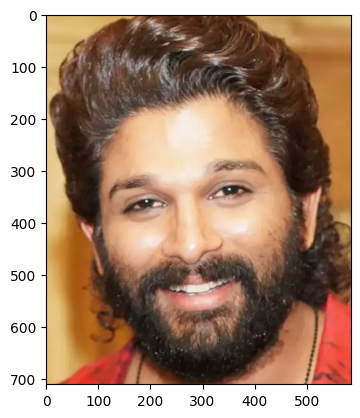

In [276]:
img = cv2.imread('./test_images/1859737-6alluarjun.webp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cropper.crop_face(img)
plt.imshow(img)

In [277]:
%%time
db = client['optimized_image_db']
person = check_in_collection(img, db)

if not person:
    print("Not found in collection")
    person = check_in_database(img, db)
else:
    print("Found in collection")
    
if person:
    print(f"Person identified as {person}")
else:
    print("Person not found")

Found in collection
Person identified as allu arjun
CPU times: user 176 ms, sys: 13.8 ms, total: 189 ms
Wall time: 36.4 ms


In [278]:
def check_in_collection_control(img, db):
    # print("test")
    collection = db['vectors']
    img_vector = img_to_encoding(img)

    img_vector = [img_vector.flatten()]

    vectors = collection.find({})
    img_vector = np.array(img_vector)
    # print(vectors)
    for vector in vectors:
        if np.linalg.norm(np.array(vector['encoding']) - img_vector) < 0.85:
            return vector['name']
    return None

In [279]:
%%time
db = client['unoptimized_image_db']
person = check_in_collection_control(img, db)

if person:
    print(f"Person identified as {person}")
else:
    print("Person not found")

Person identified as allu arjun
CPU times: user 235 ms, sys: 39.1 ms, total: 274 ms
Wall time: 53.6 ms


In [280]:
# drop the databases
client.drop_database('optimized_image_db')
client.drop_database('unoptimized_image_db')